In [1]:
from copy import deepcopy
import logging
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.extmath import cartesian
from sklearn.neighbors import NearestNeighbors
import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.patches as patches
import seaborn as sns

import p_mice

random_seed = 0

In [2]:
logging.basicConfig(level=logging.INFO)

# Demo

p-mICE application on breast_cancer dataset in sklearn.datasets

## Data preparation

In [3]:
'''
breast_cancer dataset preparation
ar_X (2d-array[float]): explanatory variables
ar_y (1d-array[int]): response variable: {0: 'benign', 1: 'malignant'}
ar_feature_names (1d-array[str]): 
'''
# breast_cancer dataset
dataset = load_breast_cancer()
ar_X = dataset['data'] # No categorical features
ar_y = 1 - dataset['target'] # 0: benign, 1: malignant
ar_feature_names = dataset['feature_names']

## EDA

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


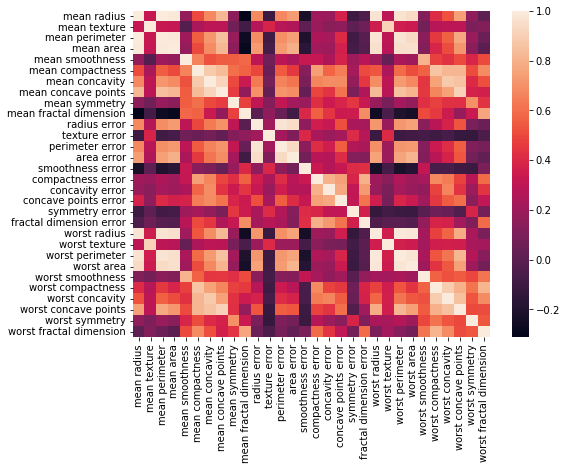

In [4]:
# correlation
df_X = pd.DataFrame(ar_X, columns=ar_feature_names)
plt.figure(figsize=(8, 6))
sns.heatmap(df_X.corr())
plt.show()

## Data preprocessing

In [5]:
# split into train/test data
ar_train_idx, ar_test_idx = train_test_split(np.arange(ar_y.shape[0]), 
                                             test_size=0.2, random_state=random_seed, stratify=ar_y)

ar_train_X = ar_X[ar_train_idx]
ar_test_X = ar_X[ar_test_idx]
ar_train_y = ar_y[ar_train_idx]
ar_test_y = ar_y[ar_test_idx]

## Model construction

In [6]:
# hyperparameter tuning
# config
param_grid = {'max_depth': [3, 5, 7, 9],
              'n_estimators': [30, 50, 70, 90, 110]}

In [7]:
# grid search cv
model = xgb.XGBClassifier(random_state=random_seed)
gscv = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5)
gscv.fit(ar_train_X, ar_train_y)
# hyper_parameters
logging.info('Best params: {}'.format(gscv.best_params_))

INFO:root:Best params: {'max_depth': 5, 'n_estimators': 90}


In [8]:
# model construction
model = gscv.best_estimator_
model.fit(ar_train_X, ar_train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=90,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

## Model evaluation

In [9]:
# auc_score
auc_score = roc_auc_score(ar_test_y, model.predict_proba(ar_test_X)[:,1])
logging.info('AUC: {:.3f}'.format(auc_score))

INFO:root:AUC: 0.988


In [10]:
# important features -> intervention_variables
intervention_variables = list(ar_feature_names[model.feature_importances_.argsort()[::-1][:2]])
logging.info('Important features: {}'.format(intervention_variables))

INFO:root:Important features: ['mean concave points', 'worst perimeter']


# ICE/p-mICE (Single record)

## setting

In [11]:
# intervention_variables
intervention_variables = ['mean concave points', 'worst perimeter']
# index of interest
idx = 42

In [12]:
record = ar_test_X[idx].reshape(-1, ar_test_X.shape[1])

## ICE

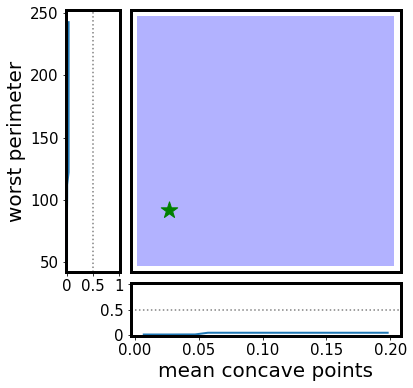

In [13]:
'''
model (Model): Trained ML model
ar_feature_names (1d-array[str]): Feature names
intervention_variables (list[str]): Two feature names to set intervention variables
record (2d-array[float]): Record of interest
ar_ref_X (2d-array[float]): Reference dataset for ICE
'''
# initialize
pdc_params = p_mice.PdcParams(model, ar_feature_names, intervention_variables)
# ICE
pdc_params = p_mice.calc_ice(pdc_params, record, ar_ref_X=ar_train_X)
# plot
p_mice.plot_phase_diagrams(pdc_params)

## p-mICE

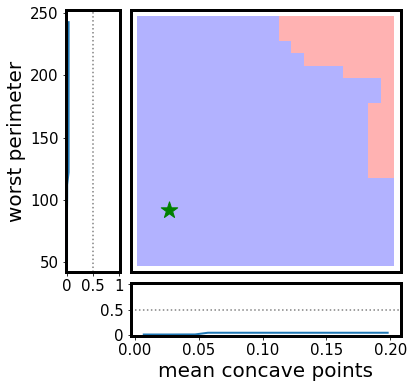

In [14]:
'''
model (Model): Trained ML model
ar_feature_names (1d-array[str]): Feature names
intervention_variables (list[str]): Two feature names to set intervention variables
record (2d-array[float]): Record of interest
ar_ref_X (2d-array[float]): Reference dataset for p-mICE
ar_ref_y (1d-array[int]): Label of ar_ref_X
'''
# initialize
pdc_params = p_mice.PdcParams(model, ar_feature_names, intervention_variables)
# p-mICE
pdc_params = p_mice.calc_p_mice(pdc_params, record, ar_ref_X=ar_train_X, ar_ref_y=ar_train_y)
# plot
p_mice.plot_phase_diagrams(pdc_params)

# ICE/p-mICE (Multiple records)

## setting

In [15]:
# intervention_variables
intervention_variables = ['mean concave points', 'worst perimeter']

INFO:root:i: 0
INFO:root:ICE:


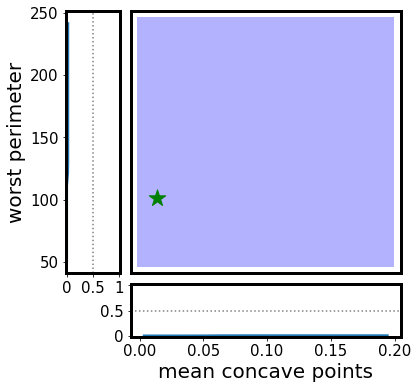

INFO:root:p-mICE:


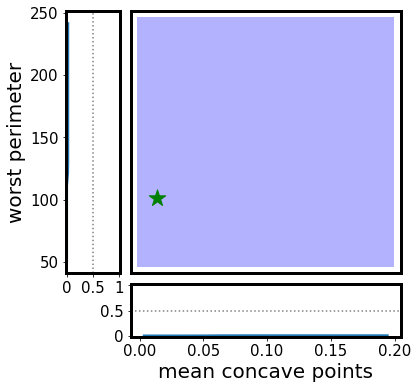

INFO:root:i: 1
INFO:root:ICE:


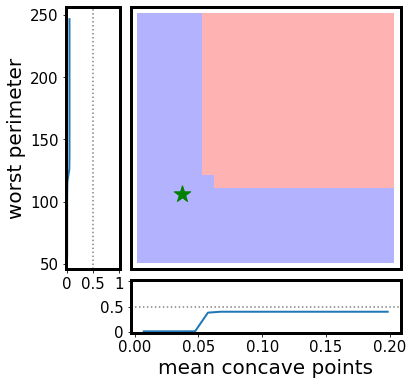

INFO:root:p-mICE:


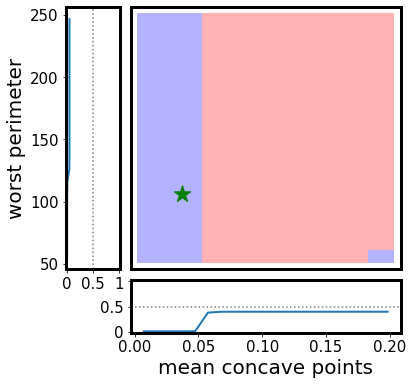

INFO:root:i: 2
INFO:root:ICE:


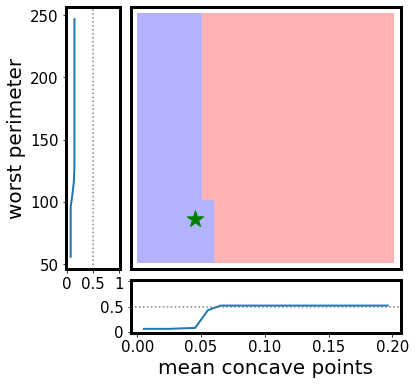

INFO:root:p-mICE:


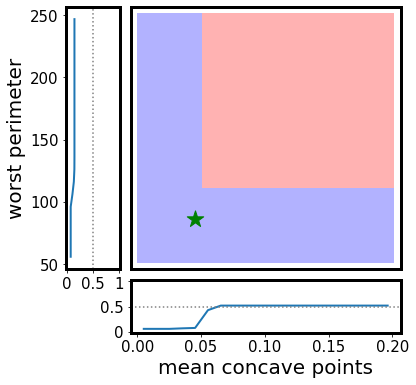

INFO:root:i: 3
INFO:root:ICE:


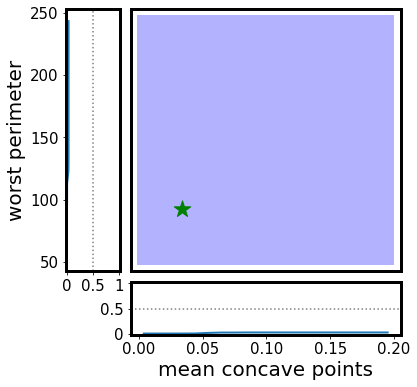

INFO:root:p-mICE:


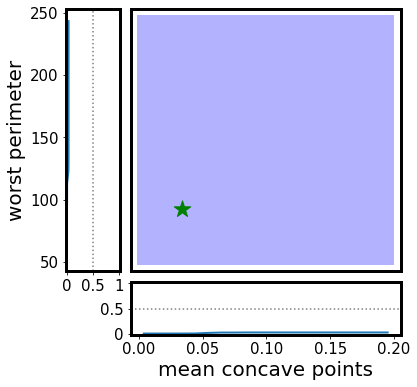

INFO:root:i: 4
INFO:root:ICE:


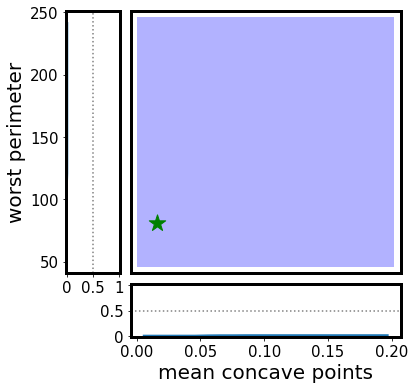

INFO:root:p-mICE:


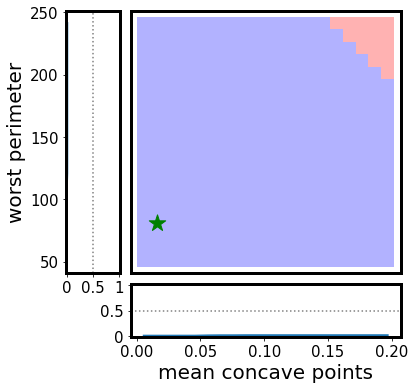

INFO:root:i: 5
INFO:root:ICE:


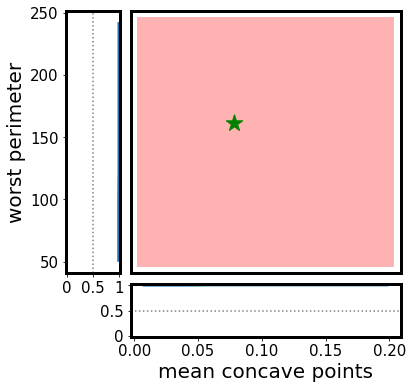

INFO:root:p-mICE:


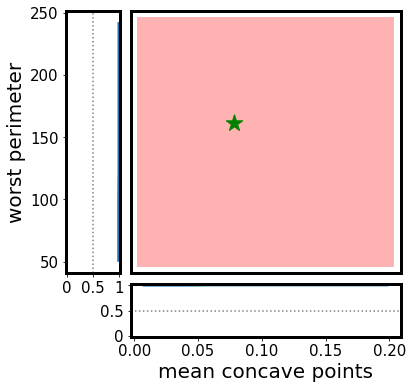

INFO:root:i: 6
INFO:root:ICE:


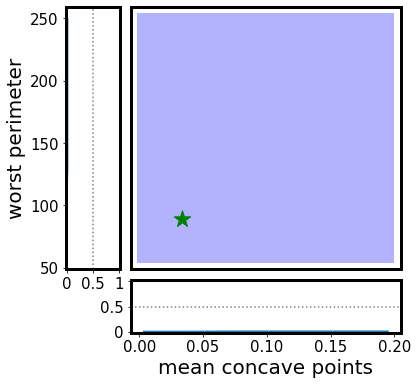

INFO:root:p-mICE:


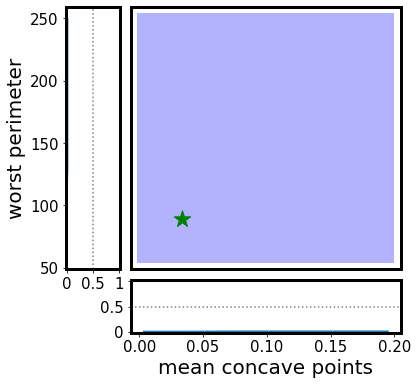

INFO:root:i: 7
INFO:root:ICE:


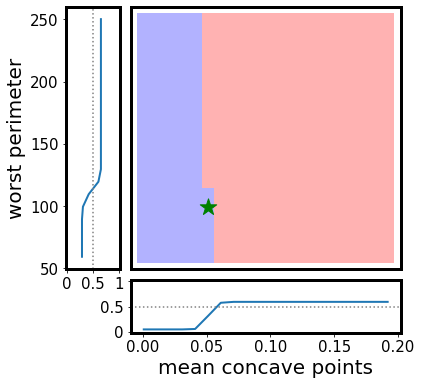

INFO:root:p-mICE:


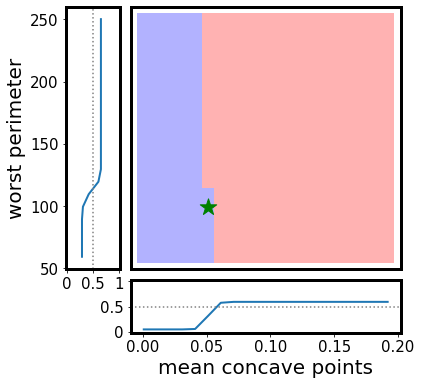

INFO:root:i: 8
INFO:root:ICE:


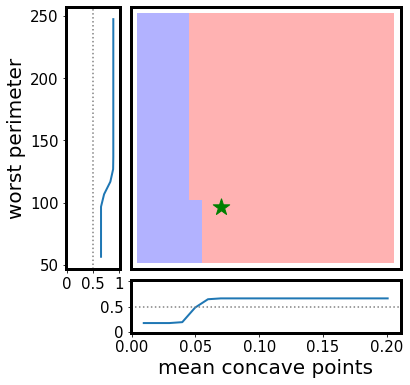

INFO:root:p-mICE:


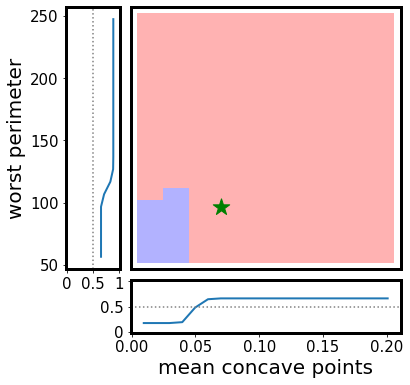

INFO:root:i: 9
INFO:root:ICE:


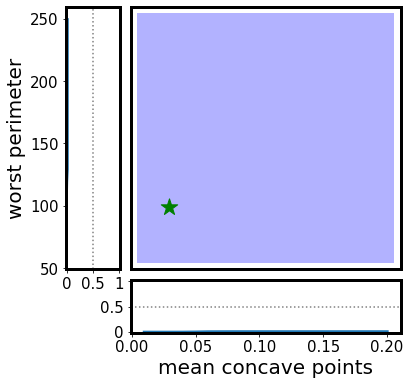

INFO:root:p-mICE:


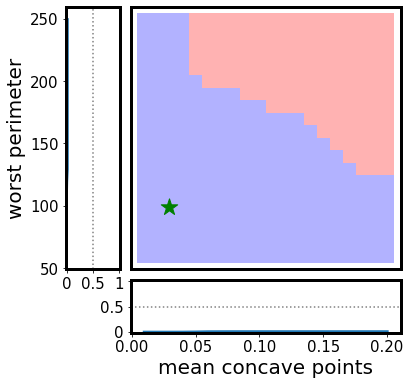

In [16]:
for i in range(10):
    logging.info('i: {}'.format(i))
    record = ar_test_X[i].reshape(-1, ar_test_X.shape[1])
    
    # ICE
    logging.info('ICE:')
    # initialize
    pdc_params = p_mice.PdcParams(model, ar_feature_names, intervention_variables)
    # ICE
    pdc_params = p_mice.calc_ice(pdc_params, record, ar_ref_X=ar_train_X)
    # plot
    p_mice.plot_phase_diagrams(pdc_params)   
    
    # p-mICE
    logging.info('p-mICE:')
    # initialize
    pdc_params = p_mice.PdcParams(model, ar_feature_names, intervention_variables)
    # p-mICE
    pdc_params = p_mice.calc_p_mice(pdc_params, record, ar_ref_X=ar_train_X, ar_ref_y=ar_train_y)
    # plot
    p_mice.plot_phase_diagrams(pdc_params)